# Load libraries

In [1]:
## load libraries

from pyDOE import *
from scipy.stats.distributions import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow import keras
from pickle import dump, load
from matplotlib.gridspec import GridSpec
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset

In [2]:
## load all dataset
xy_pd = pd.read_csv('dataset.csv')
x_data = xy_pd.iloc[:,1:-1]
y_data = np.array(xy_pd.iloc[:,-1]).reshape(-1,1)

print("data shape(x, y): ", np.shape(x_data), np.shape(y_data))

x_train = np.array(pd.read_csv('x_train.csv').iloc[:,1]).reshape(-1,1)
y_train = np.array(pd.read_csv('y_train.csv').iloc[:,1]).reshape(-1,1)

x_val = np.array(pd.read_csv('x_val.csv').iloc[:,1]).reshape(-1,1)
y_val = np.array(pd.read_csv('y_val.csv').iloc[:,1]).reshape(-1,1)

x_test = np.array(pd.read_csv('x_test.csv').iloc[:,1]).reshape(-1,1)
y_test = np.array(pd.read_csv('y_test.csv').iloc[:,1]).reshape(-1,1)

data shape(x, y):  (100, 1) (100, 1)


# Dataset preprocessing

In [3]:
## load scalers

x_scaler = load(open('./x_minmax_scaler.pkl', 'rb'))
y_scaler = load(open('./y_minmax_scaler.pkl', 'rb'))

In [4]:
## scale transformed

x_trainsc = x_scaler.transform(np.array(x_train).reshape(-1,1))
y_trainsc = y_scaler.transform(np.array(y_train).reshape(-1,1))

x_valsc = x_scaler.transform(np.array(x_val).reshape(-1,1))
y_valsc = y_scaler.transform(np.array(y_val).reshape(-1,1))

x_testsc = x_scaler.transform(np.array(x_test).reshape(-1,1))
y_testsc = y_scaler.transform(np.array(y_test).reshape(-1,1))

C:\Users\MOBIS\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\MOBIS\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\MOBIS\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(




#  KFOLD-based training

In [5]:
## 성능지표 출력

def performance(y_true, y_pred):
    _rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    _nrmse = (_rmse)/(np.max(y_train)-np.min(y_train))
    
    corr_matrix = np.corrcoef(y_true[:,0], y_pred[:,0])
    corr_xy  = corr_matrix[0,1]
    _r2 = corr_xy**2
    return _rmse, _nrmse, _r2

In [6]:
## FNN load 
from keras.models import load_model 
fnn_name = "fnn_model.h5"
fnn_model = load_model(fnn_name, compile = False)
fnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-1 (Dense)            (None, 16)                32        
                                                                 
 Hidden-2 (Dense)            (None, 128)               2176      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Hidden-3 (Dense)            (None, 32)                4128      
                                                                 
 Hidden-4 (Dense)            (None, 16)                528       
                                                                 
 Hidden-5 (Dense)            (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0


## INN structure

In [7]:
def inn_model(x, y, hidden_layers, d_o, l_rate):
    
    # set parameters
    input_dim = np.shape(x)[1]        # input dimensions
    output_dim = np.shape(y)[1]
    hidden_layers = hidden_layers    # hidden layer dimensions
    d_o = d_o                      # dropout확률
    
    # Initialize model
    model = keras.Sequential(name = "INN_network")
    # hidden layer-1
    model.add(keras.layers.Dense(hidden_layers[0], activation='relu', input_shape=(input_dim, ), name='Hidden-1'))
    # hidden layer-2
    model.add(keras.layers.Dense(hidden_layers[1], activation='elu', name='Hidden-2'))
    model.add(keras.layers.Dropout(d_o))
    # hidden layer-3
    model.add(keras.layers.Dense(hidden_layers[2], activation='elu', name='Hidden-3'))
#     model.add(keras.layers.Dropout(d_o))
    # hidden layer-4
    model.add(keras.layers.Dense(hidden_layers[3], activation='relu', name='Hidden-4'))
    # hidden layer-5
    model.add(keras.layers.Dense(hidden_layers[4], activation='elu', name='Hidden-5'))
    model.add(keras.layers.Dropout(d_o))

    # hidden layer-6
    model.add(keras.layers.Dense(hidden_layers[5], activation='elu', name='Hidden-6'))
    model.add(keras.layers.Dropout(d_o))
    # hidden layer-7
    model.add(keras.layers.Dense(hidden_layers[6], activation='elu', name='Hidden-7'))
    # hidden layer-8
    model.add(keras.layers.Dense(hidden_layers[7], activation='elu', name='Hidden-8'))
    # 출력층
    model.add(keras.layers.Dense(output_dim))
    
    # compile model
    adam_opti = keras.optimizers.Adam(lr=l_rate)
    model.compile(loss='mse', optimizer=adam_opti,metrics=['accuracy'])

    
    return model

In [8]:
import warnings
warnings.filterwarnings(action='ignore') 

# set parameters
input_dim = np.shape(x_data)[1]        # input dimensions
output_dim = np.shape(y_data)[1]
input_ = tf.keras.Input(shape=(input_dim,))
output_ = tf.keras.Input(shape=(output_dim,))
    
# dnn hyperparameter 설정
hidden_layer = [16, 64, 16, 128, 16, 32, 128, 16]
d_o = 0.2
epoch = 800
l_rate = 0.001

# INN 정의
inn_run = inn_model(y_trainsc, x_trainsc, hidden_layer, d_o, l_rate)
inn_run.summary()

# FNN 정의
fnn_ = tf.keras.Model(input_, fnn_model(input_), name = "FNN_network")

# Tandem network 정의
Tandem = tf.keras.Model(output_, fnn_(inn_run(output_)), name = "Tandem_network")

Tandem.summary()

Model: "INN_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-1 (Dense)            (None, 16)                32        
                                                                 
 Hidden-2 (Dense)            (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Hidden-3 (Dense)            (None, 16)                1040      
                                                                 
 Hidden-4 (Dense)            (None, 128)               2176      
                                                                 
 Hidden-5 (Dense)            (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                

In [9]:
# Trainable Layer check
pd.set_option("max_colwidth", -1)
layers = [(layer, layer.name, layer.trainable) for layer in Tandem.layers]
pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

fnn_layer = Tandem.get_layer("FNN_network")
fnn_layer.trainable = False

# Trainable Layer recheck
pd.set_option("max_colwidth", -1)
layers = [(layer, layer.name, layer.trainable) for layer in Tandem.layers]
pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001DF8E76CC70>,input_2,True
1,<keras.engine.sequential.Sequential object at 0x000001DF8E75A4C0>,INN_network,True
2,<keras.engine.functional.Functional object at 0x000001DF8E803460>,FNN_network,False


In [10]:
## 모델 학습 그래프 출력

def plot_loss(history, title=None):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    
    return plt

In [28]:
## 성능지표 출력

def performance(y_true, y_pred):
    _rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    _nrmse = (_rmse)/(np.max(y_true)-np.min(y_true))
    
    corr_matrix = np.corrcoef(y_true[:,0], y_pred[:,0])
    corr_xy  = corr_matrix[0,1]
    _r2 = corr_xy**2
    return _rmse, _nrmse, _r2

Model: "Tandem_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 INN_network (Sequential)    (None, 1)                 13249     
                                                                 
 FNN_network (Functional)    (None, 1)                 13249     
                                                                 
Total params: 26,498
Trainable params: 13,249
Non-trainable params: 13,249
_________________________________________________________________
1/1 [==============================] - 0s 150ms/step


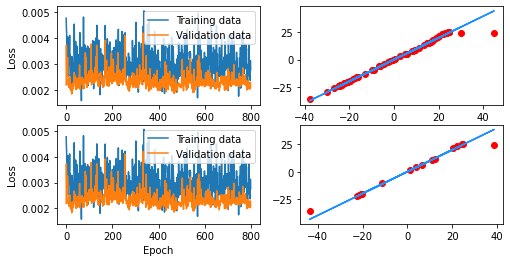

In [29]:
# compile model
adam_opti = keras.optimizers.Adam(lr=l_rate)
Tandem.compile(loss='mse', optimizer=adam_opti,metrics=['mse','accuracy'])
    
# # callback-checkpoint 생성
# ck_path = "cb_ck"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = ck_path,
#                                                 save_weights_only = True,
#                                                 verbose=0)
history = Tandem.fit(y_trainsc, y_trainsc,
                    batch_size=32,
                    epochs=epoch,
                    verbose=0,
                    validation_data = (y_valsc, y_valsc))
#                     callbacks = [cp_callback])
Tandem.summary()



Tandem.save("tandem_model.h5")

y_trainpredsc = Tandem.predict(y_trainsc)
y_trainpredsc = y_trainpredsc.reshape(-1,1)
y_trainpred = y_scaler.inverse_transform(y_trainpredsc)
y_train = y_scaler.inverse_transform(y_trainsc)
y_valpredsc = Tandem.predict(y_valsc)
y_valpredsc = y_valpredsc.reshape(-1,1)
y_valpred = y_scaler.inverse_transform(y_valpredsc)
y_val = y_scaler.inverse_transform(y_valsc)

train_pfm = performance(y_train, y_trainpred)
val_pfm = performance(y_val, y_valpred)

each_data_pfm = list(train_pfm)
each_data_pfm = np.concatenate((each_data_pfm, list(val_pfm)), axis=0)
each_data_pfm = each_data_pfm.reshape(1,-1)

#################결과저장##############################
data_pfm = list(each_data_pfm)

####################plot##########################
fig = plt.figure(figsize=(8,4))

gs = GridSpec(nrows=2, ncols=2, 
              width_ratios=[1,1],height_ratios=[1,1])

ax0 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

if not isinstance(history, dict):
    history = history.history
ax0.plot(history['loss'])           # loss
ax0.plot(history['val_loss'])       # validation
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax0.legend(['Training data', 'Validation data'], loc=0)

if not isinstance(history, dict):
    history = history.history
ax3.plot(history['mse'])           # loss
ax3.plot(history['val_mse'])       # validation
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['Training data', 'Validation data'], loc=0)


ax1.plot(y_train, y_train, color = 'dodgerblue', label='ground truth')
ax1.scatter(y_train, y_trainpred, color = 'red', label='prediction')

ax2.plot(y_val, y_val, color = 'dodgerblue', label='ground truth')
ax2.scatter(y_val, y_valpred, color = 'red', label='prediction')

plt.show()

In [30]:
pd.DataFrame(history)

,loss,mse,accuracy,val_loss,val_mse,val_accuracy
0,0.004773,0.004773,0.015625,0.002186,0.002186,0.0625
1,0.004393,0.004393,0.015625,0.003725,0.003725,0.0625
2,0.004220,0.004220,0.015625,0.002955,0.002955,0.0625
3,0.003048,0.003048,0.015625,0.002586,0.002586,0.0625
4,0.003484,0.003484,0.015625,0.002648,0.002648,0.0625
...,...,...,...,...,...,...
795,0.002566,0.002566,0.015625,0.002079,0.002079,0.0625
796,0.002690,0.002690,0.015625,0.002024,0.002024,0.0625
797,0.002365,0.002365,0.015625,0.002227,0.002227,0.0625
798,0.003129,0.003129,0.015625,0.002289,0.002289,0.0625


In [31]:
# Trainable Layer check
pd.set_option("max_colwidth", -1)
layers = [(layer, layer.name, layer.trainable) for layer in Tandem.layers]
pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001DF8ECB0760>,input_2,True
1,<keras.engine.sequential.Sequential object at 0x000001DF8ECB0040>,INN_network,True
2,<keras.engine.functional.Functional object at 0x000001DF9312AC10>,FNN_network,True


In [32]:
##################performance###########################
    
colname = ["(train) RMSE", "(train) nRMSE", "(train) R2", "(val) RMSE", "(val) nRMSE", "(val) R2"]
pd_pfm = pd.DataFrame(data_pfm, columns = colname, index = ["FNN model"])
pd_pfm

,(train) RMSE,(train) nRMSE,(train) R2,(val) RMSE,(val) nRMSE,(val) R2
FNN model,2.671311,0.032378,0.981717,4.042516,0.049052,0.973056


# INN Layer : 최적 해 출력 결과

In [15]:
## INN load 
from keras.models import load_model 
tandem_name = "tandem_model.h5"
Tandem = load_model(tandem_name, compile = False)
Tandem.summary()

Model: "Tandem_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 INN_network (Sequential)    (None, 1)                 13249     
                                                                 
 FNN_network (Functional)    (None, 1)                 13249     
                                                                 
Total params: 26,498
Trainable params: 13,249
Non-trainable params: 13,249
_________________________________________________________________


In [16]:
## load scalers
x_scaler = load(open('./x_minmax_scaler.pkl', 'rb'))
y_scaler = load(open('./y_minmax_scaler.pkl', 'rb'))

# train data
x_train = np.array(pd.read_csv('x_train.csv').iloc[:,1])
y_train = np.array(pd.read_csv('y_train.csv').iloc[:,1])

# validation data
x_val = np.array(pd.read_csv('x_val.csv').iloc[:,1])
y_val = np.array(pd.read_csv('y_val.csv').iloc[:,1])

# test data
x_test = np.array(pd.read_csv('x_test.csv').iloc[:,1])
y_test = np.array(pd.read_csv('y_test.csv').iloc[:,1])

Model: "INN_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-1 (Dense)            (None, 16)                32        
                                                                 
 Hidden-2 (Dense)            (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Hidden-3 (Dense)            (None, 16)                1040      
                                                                 
 Hidden-4 (Dense)            (None, 128)               2176      
                                                                 
 Hidden-5 (Dense)            (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                

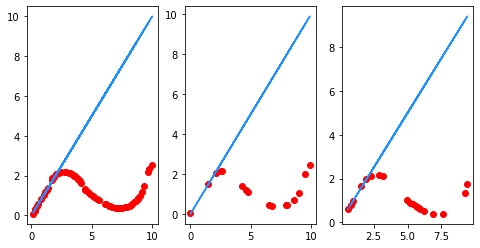

In [17]:
## Extract INN layer
inn_layer = Tandem.get_layer("INN_network")
inn_layer.summary()

## train prediction
y_trainsc = y_scaler.transform(y_train.reshape(-1,1))
x_trainpredsc = inn_layer.predict(y_trainsc)
x_trainpred = x_scaler.inverse_transform(x_trainpredsc)

## val prediction
y_valsc = y_scaler.transform(y_val.reshape(-1,1))
x_valpredsc = inn_layer.predict(y_valsc)
x_valpred = x_scaler.inverse_transform(x_valpredsc)

## test prediction
y_testsc = y_scaler.transform(y_test.reshape(-1,1))
x_testpredsc = inn_layer.predict(y_testsc)
x_testpred = x_scaler.inverse_transform(x_testpredsc)

####################   x gt & prediction plot   ##########################

fig = plt.figure(figsize=(8,4))

gs = GridSpec(nrows=1, ncols=3, width_ratios=[1,1,1])

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax0.plot(x_train, x_train, color = 'dodgerblue', label='ground truth')
ax0.scatter(x_train, x_trainpred, color = 'red', label='prediction')

ax1.plot(x_val, x_val, color = 'dodgerblue', label='ground truth')
ax1.scatter(x_val, x_valpred, color = 'red', label='prediction')

ax2.plot(x_test, x_test, color = 'dodgerblue', label='ground truth')
ax2.scatter(x_test, x_testpred, color = 'red', label='prediction')

plt.show()

2/2 [==============================] - 0s 2ms/step


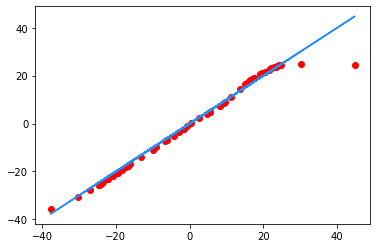

In [18]:
## comparison tandem with fnn>inn for train dataset

fnn_layer = Tandem.get_layer("FNN_network")
y_trainpredsc = fnn_layer.predict(x_trainpredsc)
y_trainpred = y_scaler.inverse_transform(y_trainpredsc)
plt.plot(y_train, y_train, color = 'dodgerblue', label='ground truth')
plt.scatter(y_train, y_trainpred, color = 'red', label='prediction')
plt.show()

1/1 [==============================] - 0s 94ms/step


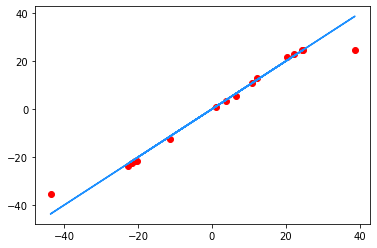

In [19]:
## comparison tandem with fnn>inn for val dataset

fnn_layer = Tandem.get_layer("FNN_network")
y_valpredsc = fnn_layer.predict(x_valpredsc)
y_valpred = y_scaler.inverse_transform(y_valpredsc)
plt.plot(y_val, y_val, color = 'dodgerblue', label='ground truth')
plt.scatter(y_val, y_valpred, color = 'red', label='prediction')
plt.show()

1/1 [==============================] - 0s 20ms/step


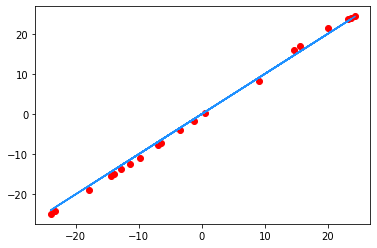

In [20]:
## comparison tandem with fnn>inn for test dataset

fnn_layer = Tandem.get_layer("FNN_network")
y_testpredsc = fnn_layer.predict(x_testpredsc)
y_testpred = y_scaler.inverse_transform(y_testpredsc)
plt.plot(y_test, y_test, color = 'dodgerblue', label='ground truth')
plt.scatter(y_test, y_testpred, color = 'red', label='prediction')
plt.show()